# Campbell-Cochrane habit model

## (c)

In [1]:
import torch
import torch.nn as nn
torch.manual_seed(1234)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
from habit_model import CCHabitModel
from early_stop import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3)

In [2]:
def train_epoch(model, inputs, criterion, optimizer):
    model.train()
    inputs = inputs.to(DEVICE)
    outputs = model(inputs)
    loss = criterion(outputs, torch.tensor(0).float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

def eval_epoch(model, inputs, criterion):  
    model.eval()
    with torch.no_grad():
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, torch.tensor(0).float())
    return loss

def train_model(n_epochs, train_inputs, valid_inputs, model, criterion, optimizer, scheduler, early_stopping=None):
    train_losses, valid_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        train_loss = train_epoch(model, train_inputs, criterion, optimizer)
        valid_loss = eval_epoch(model, valid_inputs, criterion)
        scheduler.step(valid_loss)

        train_losses.append(train_loss.detach().numpy())
        valid_losses.append(valid_loss.detach().numpy())

        if early_stopping:
            early_stopping(valid_loss, model)
            if early_stopping.early_stop:
                break
    return train_losses, valid_losses

In [3]:
def plot_loss(train_losses, valid_losses):
    fig, ax = plt.subplots(figsize=(9,6))
    ax.plot(train_losses, label='Training Loss')
    ax.plot(valid_losses, label='Validation Loss')
    ax.set_title('Losses')
    ax.set_xlabel('Epoch')
    ax.legend()
    plt.yscale('log')
    
def plot_weights(weights):
    fig, ax = plt.subplots(figsize=(9,6))
    vmax = max(abs(weights.max()), abs(weights.min()))
    ax = sns.heatmap(weights, cmap='vlag', vmin=-vmax, vmax=vmax, annot=True)
    ax.set_title('Weight Matrix')
    
def plot_PC(S, PC):
    fig, ax = plt.subplots(figsize=(9,6))
    ax.plot(S[PC>0], PC[PC>0])
    ax.set_ylabel('P/C')
    ax.set_xlabel('S')

 52%|████████████████████▏                  | 1555/3000 [01:17<01:12, 19.98it/s]


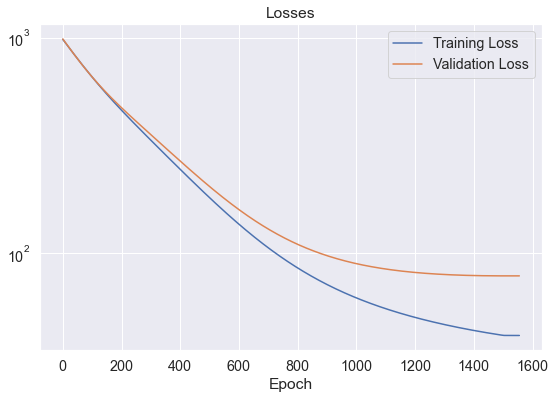

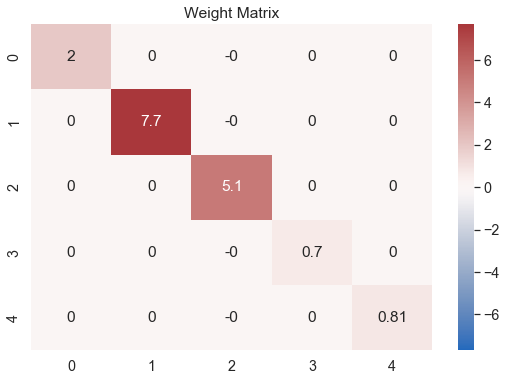

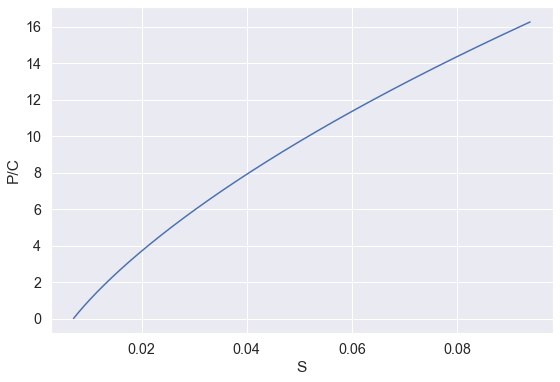

In [4]:
sigma = 1.5/100
batch_size = 1000 # number of sample random numbers
N = 1000 # number of grid points of s
train_inputs = sigma * torch.randn(batch_size, N)
valid_inputs = sigma * torch.randn(int(batch_size*0.2), N)

model = CCHabitModel(s_lower=-10, order=4).to(DEVICE)
criterion = nn.MSELoss(reduction='sum').to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10)
early_stopping = EarlyStopping(patience=20, verbose=True)

train_losses, valid_losses = train_model(3000, train_inputs, valid_inputs, model, criterion, 
                                         optimizer, scheduler, early_stopping)

plot_loss(train_losses, valid_losses)

weights = model.linear.weight.detach().numpy()
plot_weights(weights)

_ = model(train_inputs, save=True)
S = torch.load('S.pt').detach().numpy()
PC = torch.load('PC.pt').detach().numpy()
plot_PC(S, PC)

From the weight matrix, we see that $v$ is well-projected by Chebyshev's polynomials up to order two (quadratic polynomial).

### i)

 11%|████▍                                   | 336/3000 [00:16<02:11, 20.32it/s]


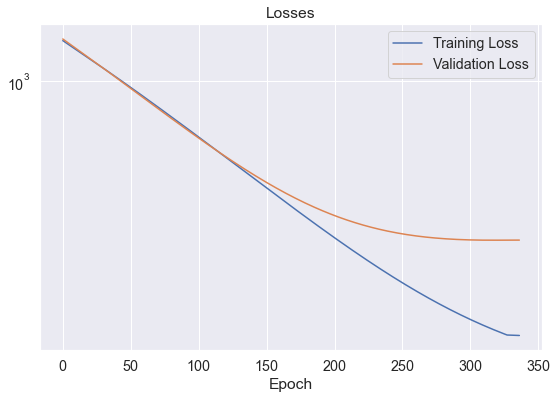

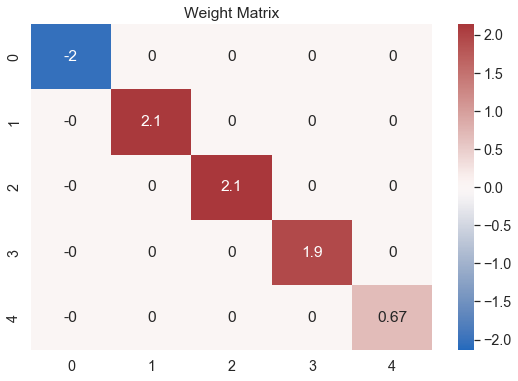

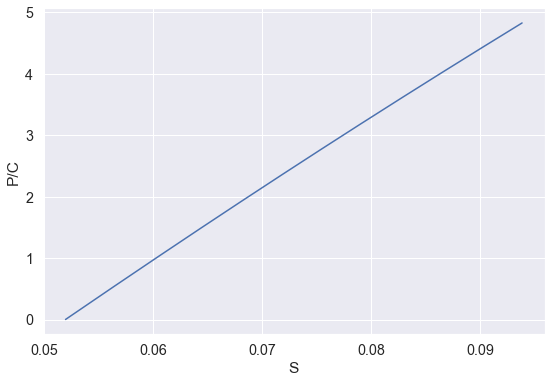

In [5]:
model = CCHabitModel(s_lower=-10, order=4, gamma=2.5).to(DEVICE)
criterion = nn.MSELoss(reduction='sum').to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10)
early_stopping = EarlyStopping(patience=20, verbose=True)

train_losses, valid_losses = train_model(3000, train_inputs, valid_inputs, model, criterion, 
                                         optimizer, scheduler, early_stopping)

plot_loss(train_losses, valid_losses)

weights = model.linear.weight.detach().numpy()
plot_weights(weights)

_ = model(train_inputs, save=True)
S = torch.load('S.pt').detach().numpy()
PC = torch.load('PC.pt').detach().numpy()
plot_PC(S, PC)

We <i>don't</i> observe a higher $\frac{P}{C}$ as $\gamma$ increases in this case. An increase in $\gamma$ makes the SDF more volatile, leading to higher equity premium required by the investors, hence lowering down $\frac{P}{C}$.

### ii)

100%|███████████████████████████████████████| 3000/3000 [02:29<00:00, 20.00it/s]


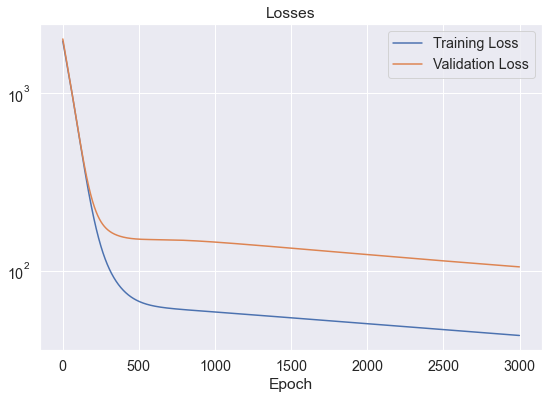

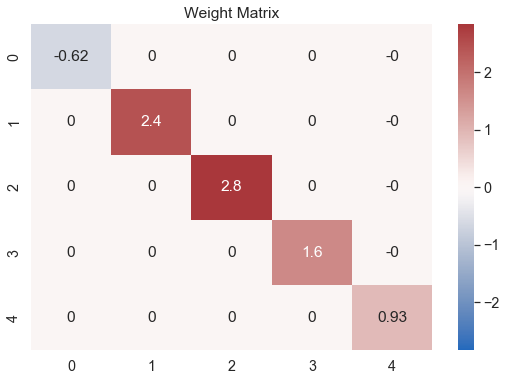

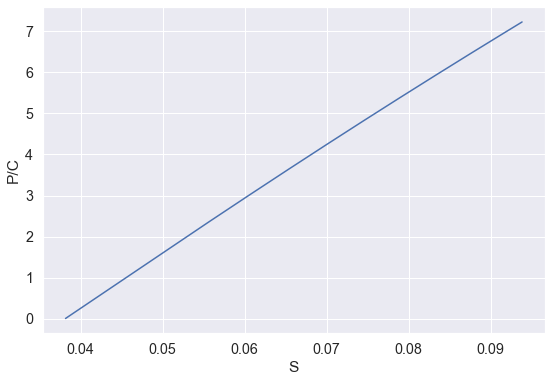

In [6]:
sigma = 2/100
train_inputs = sigma * torch.randn(batch_size, N)
valid_inputs = sigma * torch.randn(int(batch_size*0.2), N)

model = CCHabitModel(s_lower=-10, order=4).to(DEVICE)
criterion = nn.MSELoss(reduction='sum').to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10)
early_stopping = EarlyStopping(patience=20, verbose=True)

train_losses, valid_losses = train_model(3000, train_inputs, valid_inputs, model, criterion, 
                                         optimizer, scheduler, early_stopping)

plot_loss(train_losses, valid_losses)

weights = model.linear.weight.detach().numpy()
plot_weights(weights)

_ = model(train_inputs, save=True)
S = torch.load('S.pt').detach().numpy()
PC = torch.load('PC.pt').detach().numpy()
plot_PC(S, PC)

We see a downward shift of the $\frac{P}{C}$ curve when $\sigma$ increases, because more volatile consumption growth leads to a more volatile SDF. Then the required equity premium should also be high for investors (because consumption volatility is generally bad), so observed $\frac{P}{C}$ is lower.